In [102]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import logging

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from prophet.diagnostics import performance_metrics, cross_validation

warnings.filterwarnings('ignore')

In [5]:
ls

README.md                 data_cleaning.ipynb       time_series.ipynb
arima.ipynb               prophet.ipynb             variable_selection.ipynb
country_data/             proposal_slides.html      xgboost.ipynb
covid_clean.csv           proposal_slides.qmd
covid_clean_lags.csv      raw_data.csv


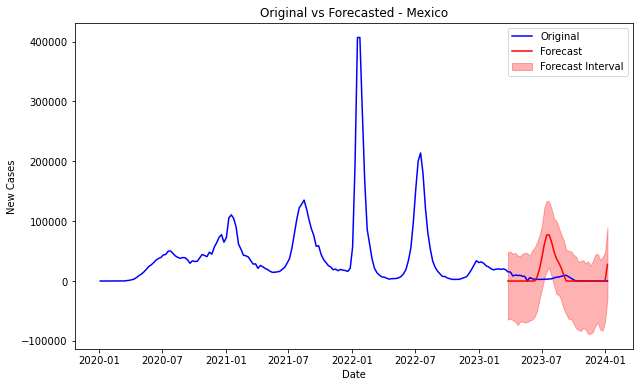

Mexico


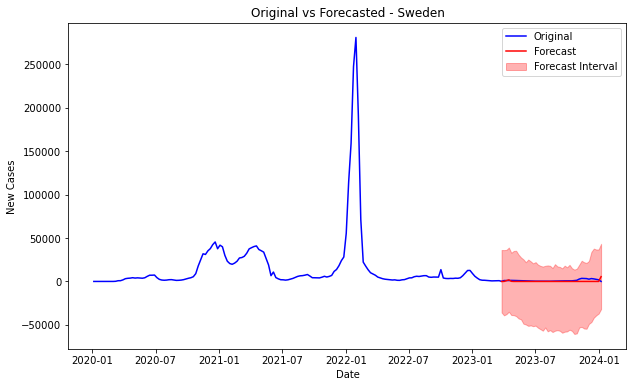

Sweden


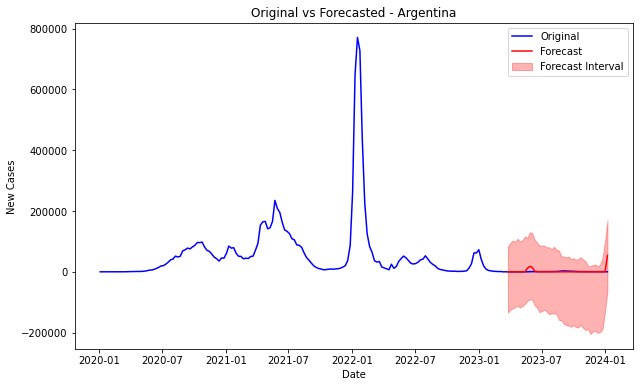

Argentina


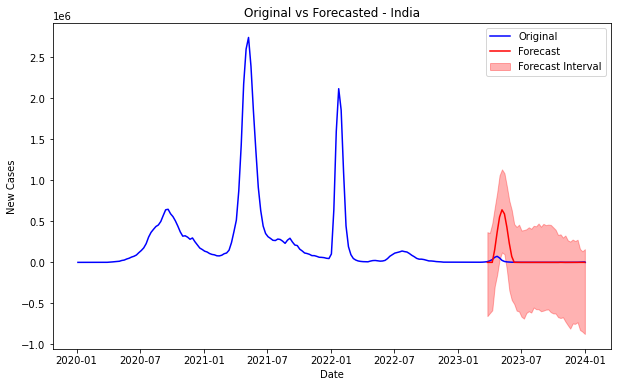

India


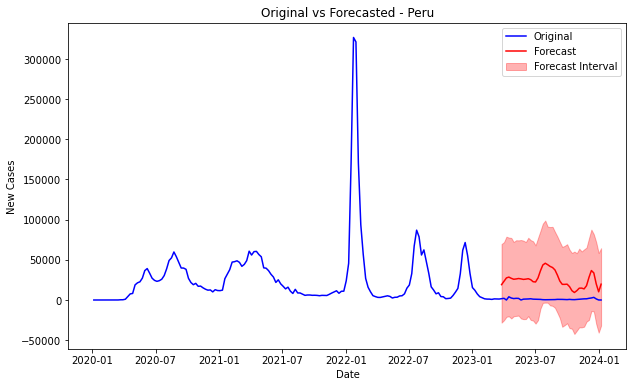

Peru


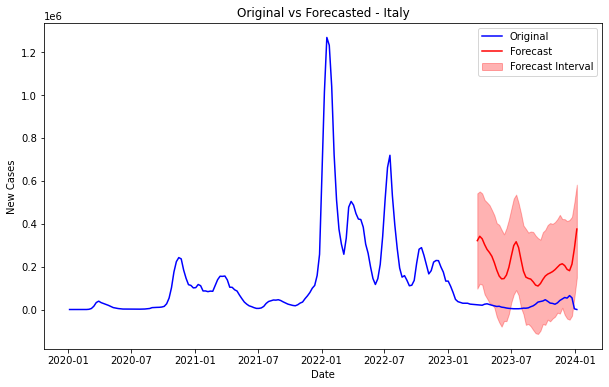

Italy


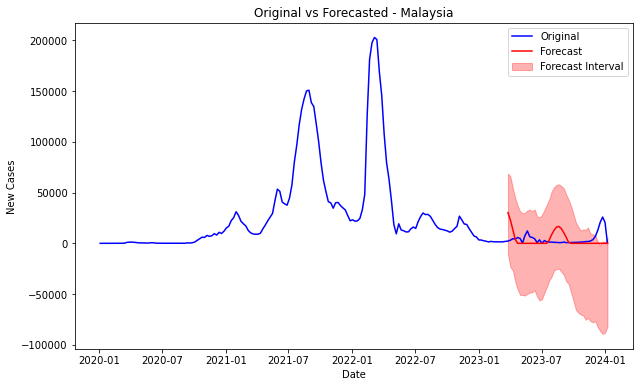

Malaysia


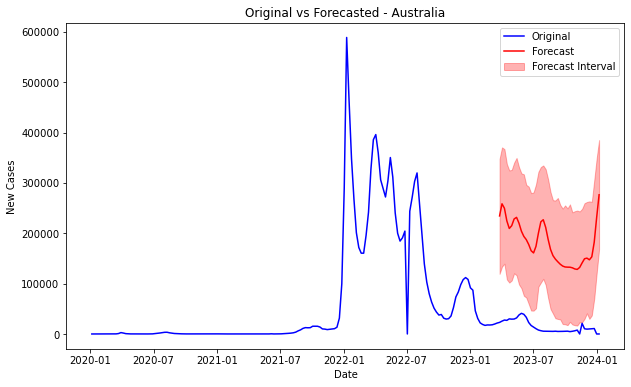

Australia


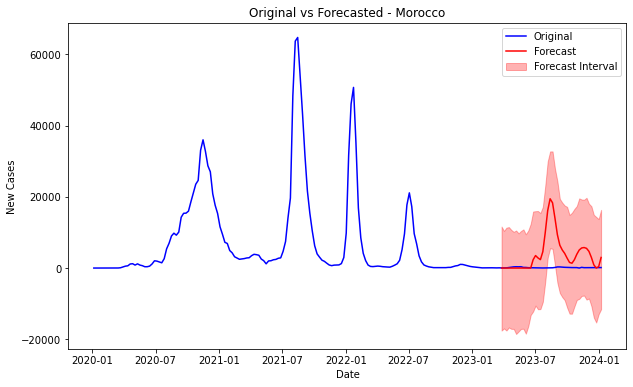

Morocco


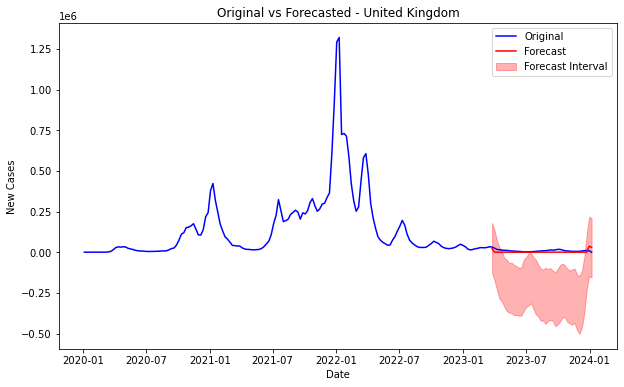

United Kingdom


In [104]:
path = 'country_data/univariate/'

files = os.listdir(path)

locations = []
rmses = []
mases = []
maes = []

for file_name in files[:]:
    if os.path.isfile(os.path.join(path, file_name)) and file_name != '.dockerenv':
        location = file_name.split('_')[0]
        df = pd.read_csv(path + file_name)
        df = df.rename(columns={'date': 'ds', 'new_cases': 'y'})
        df['ds'] = pd.to_datetime(df['ds'])

        train_size = int(len(df) * 0.8)
        train, test = df.iloc[:train_size], df.iloc[train_size:]

        holidays = pd.DataFrame({
            'holiday': 'Christmas',
            'ds': pd.to_datetime(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'])
        })

        

        model = Prophet(n_changepoints=4, holidays=holidays)
        model.fit(train)

        future = model.make_future_dataframe(periods=len(test), freq='7D')
        forecast = model.predict(future)

        forecast['yhat'] = np.maximum(forecast['yhat'], 0)

        performance = pd.merge(test, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(df['ds'], df['y'], label='Original', color='blue')
        ax.plot(performance['ds'], performance['yhat'], label='Forecast', color='red')
        ax.fill_between(performance['ds'], performance['yhat_lower'], performance['yhat_upper'],
                        color='red', alpha=0.3, label='Forecast Interval')
        ax.set_xlabel('Date')
        ax.set_ylabel('New Cases')
        ax.legend()
        ax.set_title(f'Original vs Forecasted - {location}')
        plt.show()

        mae = mean_absolute_error(performance['y'], performance['yhat'])
        rmse = np.sqrt(mean_squared_error(performance['y'], performance['yhat']))

        naive_forecast = train['y'].iloc[-1]
        naive_mae = mean_absolute_error(test['y'], np.full_like(test['y'], naive_forecast))
        mase = mae / naive_mae

        locations.append(location)
        rmses.append(rmse)
        mases.append(mase)
        maes.append(mae)
        print(location)

results = pd.DataFrame({
    'location': locations,
    'rmse': rmses,
    'mase': mases,
    'mae': maes
})

In [105]:
results

,location,rmse,mase,mae
0,Mexico,24526.514668,0.944833,13974.172528
1,Sweden,1705.615008,1.638635,1195.189085
2,Argentina,9254.174987,4.135255,3070.426769
3,India,177629.450328,7.726568,70250.321589
4,Peru,26024.477549,35.321955,24281.320828
5,Italy,201693.292398,13.416290,187124.028555
6,Malaysia,10232.610432,2.063893,7051.633083
7,Australia,171241.038755,13.108279,167070.011536
8,Morocco,6278.106924,41.017720,3900.589846
9,United Kingdom,11837.011153,0.412369,9932.281760


In [42]:
results

,location,rmse,mase,mae
0,Mexico,24865.239783,0.961319,14218.004150
1,Sweden,1492.487808,1.503036,1096.285714
2,Argentina,10050.948037,4.527912,3361.974973
3,India,165647.554663,7.054409,64139.021747
4,Peru,18203.649377,22.245908,15292.472853
5,Italy,93862.221558,4.918373,68599.120633
6,Malaysia,8825.970625,1.710757,5845.087792
7,Australia,75303.852983,4.516450,57563.873887
8,Morocco,5060.903940,26.883294,2556.473198
9,United Kingdom,11070.053889,0.384254,9255.095238


In [56]:
df = pd.read_csv('covid_clean_lags.csv')
df = df.rename(columns={'date': 'ds', 'new_cases': 'y'})
df['ds'] = pd.to_datetime(df['ds'])

In [57]:
train_percentage = 0.8

# Function to split each group into train and test sets
def group_train_test_split(group):
    train, test = train_test_split(group, train_size=train_percentage, shuffle=False)
    return train, test

# Apply the function to each country group
train_set, test_set = zip(*df.groupby('location', group_keys=False).apply(group_train_test_split))

# Concatenate the results back into dataframes
train = pd.concat(train_set)
test = pd.concat(test_set)

In [23]:
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

count = 1
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='60 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    print(count)
    count+=1

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1


deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp7ah0sg42
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp3rmdtl3j
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp468lr6zl
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpmbxb8z7o
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpt77cnu2v
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpl7hid17s
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp1nyisfob
done
done
done
124


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1


deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpa4zfno62
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpk49wvtlx
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpbr47fs0c
done
done
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpxzgmuagg
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp21jkqtqa
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpp0i6lpy5
done
done
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpsa7smkye
done
125


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1


deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpu6tqlv32
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp3t5slnyl
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpcz40tdcw
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpiaoeyce6
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpuhzh_f2_
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpt1ymu0i8
done
done
done
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpq7vx19iz
done
done
126


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1


deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp8tjys7d2
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpg66fjote
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp6edm9fb_done

deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpsw6x2vre
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpoxrbnudz
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpr9kxn4q1
done
done
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpkmjlemg8
done
done
127


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1


deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpbiny15f5
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp_fyrbyuu
done
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp3ggtjtiz
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpr2ul6htc
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmp4nvay7fh
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpnd2qqdcd
done
deleting tmpfiles dir: /var/folders/8x/j868ltjn1wjg33ylnmh2ltb00000gn/T/tmpl9o1_p16
done
done
done
done
128
     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.10   
3                      0.001                     0.01    

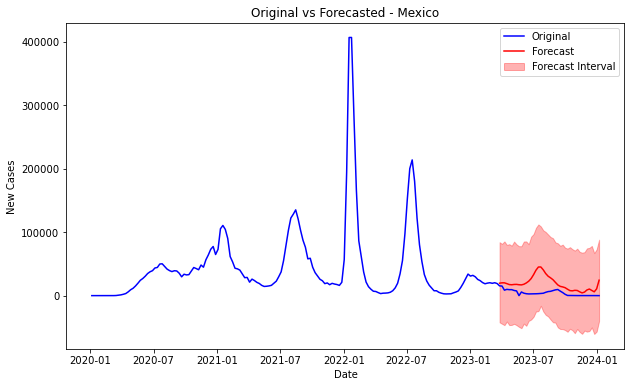

Mexico


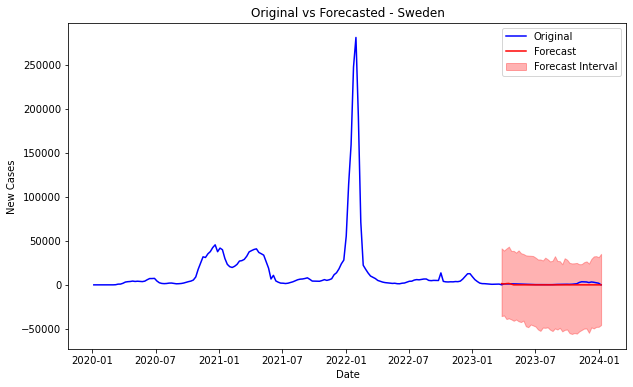

Sweden


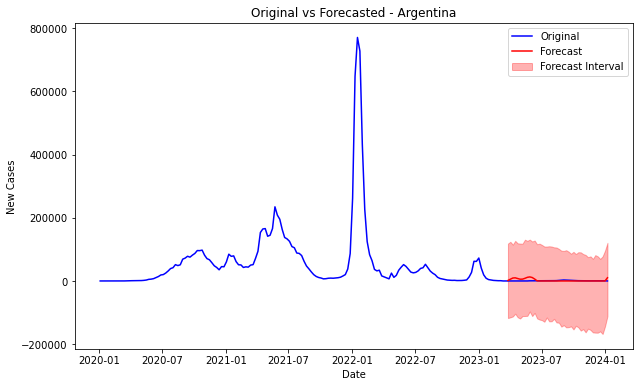

Argentina


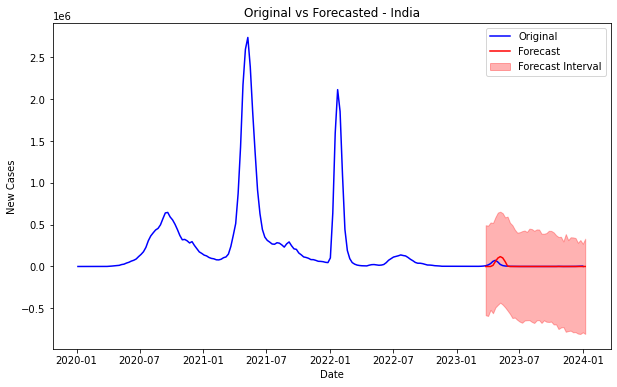

India


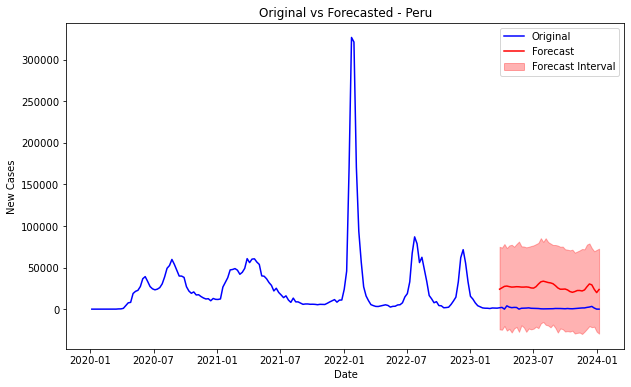

Peru


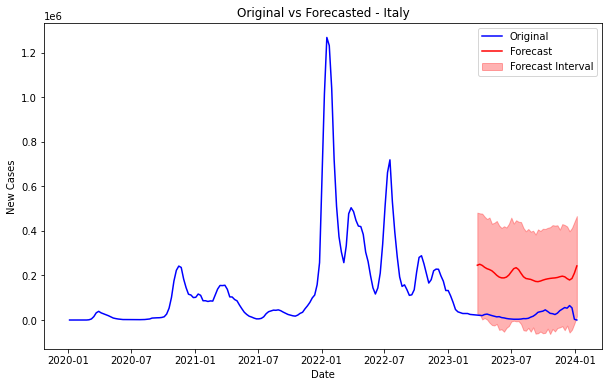

Italy


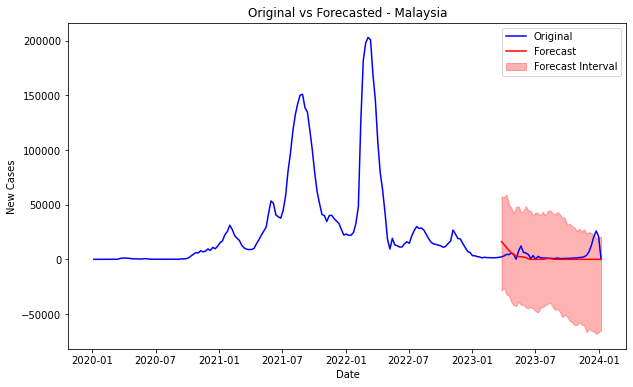

Malaysia


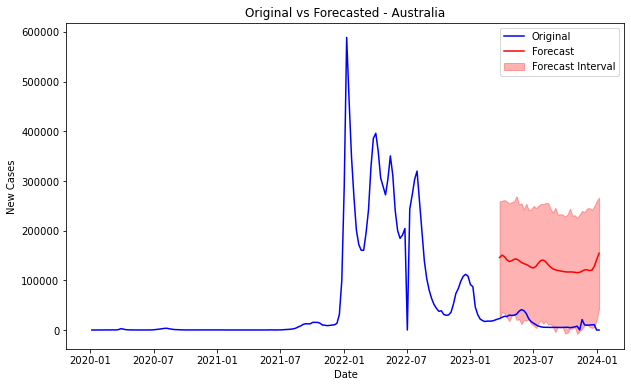

Australia


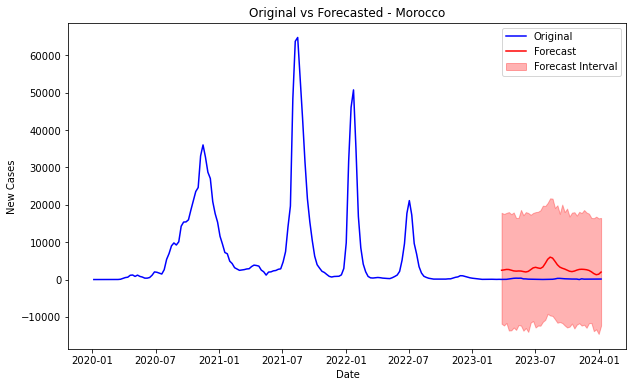

Morocco


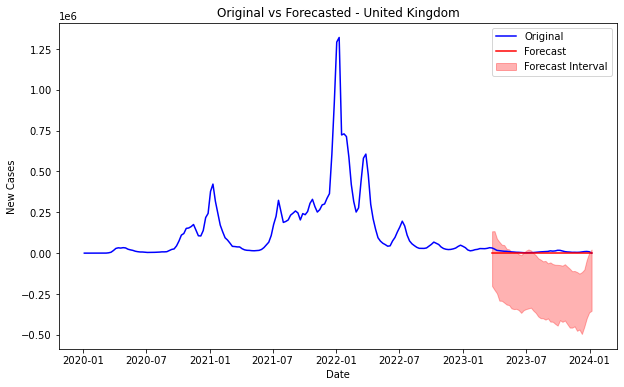

United Kingdom


In [110]:
path = 'country_data/univariate/'

files = os.listdir(path)

locations = []
rmses = []
mases = []
maes = []

main= pd.read_csv('covid_clean_lags.csv')
main = main.rename(columns={'date': 'ds', 'new_cases': 'y'})
main['ds'] = pd.to_datetime(main['ds'])

for file_name in files[:]:
    if os.path.isfile(os.path.join(path, file_name)) and file_name != '.dockerenv':
        location = file_name.split('_')[0]
        df = pd.read_csv(path + file_name)
        df = df.rename(columns={'date': 'ds', 'new_cases': 'y'})
        df['ds'] = pd.to_datetime(df['ds'])

        location_df = df#main[main['location'] == location]
        train_size = int(len(location_df) * 0.8)
        train1, test1 = location_df.iloc[:train_size], location_df.iloc[train_size:]

        model = Prophet(seasonality_prior_scale=0.01, seasonality_mode='additive')

        model.fit(train1)

        future = model.make_future_dataframe(periods=len(test1), freq='7D')

        forecast = model.predict(future)

        forecast['yhat'] = np.maximum(forecast['yhat'], 0)

        performance = pd.merge(test, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
        

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(df['ds'], df['y'], label='Original', color='blue')
        ax.plot(performance['ds'], performance['yhat'], label='Forecast', color='red')
        ax.fill_between(performance['ds'], performance['yhat_lower'], performance['yhat_upper'],
                        color='red', alpha=0.3, label='Forecast Interval')
        ax.set_xlabel('Date')
        ax.set_ylabel('New Cases')
        ax.legend()
        ax.set_title(f'Original vs Forecasted - {location}')
        plt.show()


        mae = mean_absolute_error(performance['y'], performance['yhat'])
        rmse = np.sqrt(mean_squared_error(performance['y'], performance['yhat']))

        naive_forecast = train['y'].iloc[-1]
        naive_mae = mean_absolute_error(test['y'], np.full_like(test['y'], naive_forecast))
        mase = mae / naive_mae

        locations.append(location)
        rmses.append(rmse)
        mases.append(mase)
        maes.append(mae)
        print(location)


results = pd.DataFrame({
    'location': locations,
    'rmse': rmses,
    'mase': mases,
    'mae': maes
})
                
        

,ds,iso_code,continent,location,total_cases,y,new_cases_2week_lag,new_cases_6week_lag,new_cases_6week_roll,new_cases_12week_roll,...,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,month,week,yhat,yhat_lower,yhat_upper
0,2023-03-26,AFG,Asia,Afghanistan,210080.0,331,141.0,164.0,204.000000,208.416667,...,41128772,NaN,NaN,NaN,NaN,3,13,0.0,-199372.02937,143079.924294
1,2023-03-26,ALB,Europe,Albania,333799.0,83,80.0,51.0,79.666667,83.750000,...,2842318,NaN,NaN,NaN,NaN,3,13,0.0,-199372.02937,143079.924294
2,2023-03-26,DZA,Africa,Algeria,271568.0,20,34.0,15.0,26.500000,29.250000,...,44903228,NaN,NaN,NaN,NaN,3,13,0.0,-199372.02937,143079.924294
3,2023-03-26,ASM,Oceania,American Samoa,8324.0,3,0.0,0.0,0.666667,3.250000,...,44295,NaN,NaN,NaN,NaN,3,13,0.0,-199372.02937,143079.924294
4,2023-03-26,AND,Europe,Andorra,47917.0,9,8.0,10.0,9.500000,13.833333,...,79843,NaN,NaN,NaN,NaN,3,13,0.0,-199372.02937,143079.924294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-03-26,IDN,Asia,Indonesia,6744033.0,2679,1908.0,1664.0,1872.333333,1987.666667,...,275501344,NaN,NaN,NaN,NaN,3,13,0.0,-199372.02937,143079.924294
96,2023-03-26,IRN,Asia,Iran,7584531.0,5460,3559.0,704.0,3194.000000,1949.250000,...,88550568,NaN,NaN,NaN,NaN,3,13,0.0,-199372.02937,143079.924294
97,2023-03-26,IRQ,Asia,Iraq,2465545.0,0,0.0,0.0,0.000000,0.000000,...,44496124,NaN,NaN,NaN,NaN,3,13,0.0,-199372.02937,143079.924294
98,2023-03-26,IRL,Europe,Ireland,1706794.0,982,749.0,668.0,779.833333,1168.833333,...,5023108,8156.8975,7.84,5.17,1613.0134,3,13,0.0,-199372.02937,143079.924294


In [112]:
results.to_csv('multivariate_prophet_alex_o.csv', index=False)

In [111]:
results

,location,rmse,mase,mae
0,Mexico,16816.931154,0.488140,11757.293164
1,Sweden,10800.015589,0.378081,9106.426012
2,Argentina,9756.892270,0.333281,8027.381930
3,India,29790.826114,0.697813,16807.448824
4,Peru,18571.487548,0.720169,17345.927558
5,Italy,194128.859378,8.007118,192858.691363
6,Malaysia,8537.884850,0.311542,7503.776172
7,Australia,121030.297947,5.001363,120462.342400
8,Morocco,8978.141480,0.274024,6600.109328
9,United Kingdom,11070.053889,0.384254,9255.095238


In [92]:
results

,location,rmse,mase,mae
0,Mexico,28388.488565,8.230420,19718.211424
1,Sweden,20836.904272,0.998282,2391.657212
2,Argentina,20129.322428,1.780532,4265.749117
3,India,35991.287881,5.192957,12441.141391
4,Peru,32068.589561,11.144939,26700.735135
5,Italy,202045.147550,83.711337,200553.291840
6,Malaysia,20584.234710,1.506172,3608.445833
7,Australia,129564.152003,53.730892,128726.976408
8,Morocco,21169.513742,1.910981,4578.274294
9,United Kingdom,18231.630849,0.898564,2152.755461
